In [13]:
# import libraries

import pandas as pd
import numpy as np
import string
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
%matplotlib inline
import re
from sklearn.naive_bayes import BernoulliNB
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from multiprocessing import Pool, cpu_count
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import Model

In [14]:
# Download necessary NLTK data files
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
df = pd.read_csv('/content/Combined_Data.csv', encoding='latin-1') # Try 'latin-1' encoding

In [16]:
df.head(10)

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
5,5,"every break, you must be nervous, like somethi...",Anxiety
6,6,"I feel scared, anxious, what can I do? And may...",Anxiety
7,7,Have you ever felt nervous but didn't know why?,Anxiety
8,8,"I haven't slept well for 2 days, it's like I'm...",Anxiety
9,9,"I'm really worried, I want to cry.",Anxiety


In [17]:
df.tail(10)

,Unnamed: 0,statement,status
53034,53033,I'm an adult who can not sleep alone. So I'm 3...,Anxiety
53035,53034,Neighbours Hello Iâm haveing anxiety becaus...,Anxiety
53036,53035,"Oxazepam? Hey! I have been taking oxazepam 7,5...",Anxiety
53037,53036,someone help me think rationally I know I soun...,Anxiety
53038,53037,Lorazepam side effect/after effect In the last...,Anxiety
53039,53038,Nobody takes me seriously Iâve (24M) dealt w...,Anxiety
53040,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53041,53040,Is there any way to sleep better? I can't slee...,Anxiety
53042,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety
53043,53042,I have really bad door anxiety! It's not about...,Anxiety


In [18]:
print(df.isnull().sum())

Unnamed: 0      0
statement     363
status          2
dtype: int64


In [19]:
df = df.dropna()
print(df.isnull().sum())

Unnamed: 0    0
statement     0
status        0
dtype: int64


In [20]:
df['status'].nunique()

7

In [21]:
sentiment_counts=df['status'].value_counts()
print(sentiment_counts)

status
Normal                  16343
Depression              15404
Suicidal                10651
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of Sentiments'}, xlabel='status'>

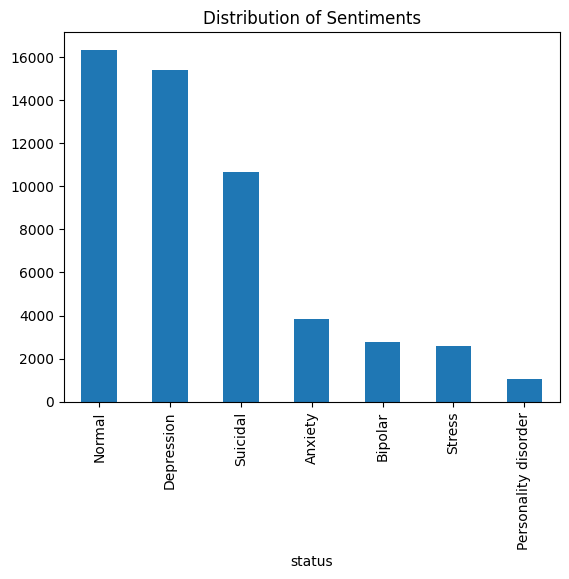

In [22]:
sentiment_counts.plot(kind='bar', title='Distribution of Sentiments')

In [23]:
df['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [24]:
df.shape

(52680, 3)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52680 entries, 0 to 53043
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  52680 non-null  object
 1   statement   52680 non-null  object
 2   status      52680 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [26]:
df.describe()

,Unnamed: 0,statement,status
count,52680,52680,52680
unique,52680,51068,7
top,0,what do you mean?,Normal
freq,1,22,16343


In [27]:
# Calculate the length of each statement
df['statement_length'] = df['statement'].apply(len)

# Display basic statistics of statement lengths
print(df['statement_length'].describe())

count    52680.000000
mean       579.421982
std        835.701200
min          2.000000
25%         80.000000
50%        317.000000
75%        755.000000
max      27588.000000
Name: statement_length, dtype: float64


In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a function to generate and display a word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate word clouds for each status
statuses = df['status'].unique()

for status in statuses:
    status_text = ' '.join(df[df['status'] == status]['statement'])
    generate_word_cloud(status_text, title=f'Word Cloud for {status}')

Output hidden; open in https://colab.research.google.com to view.

In [29]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

In [30]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


In [31]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

     # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Process text with spacy
    doc = nlp(text)

    # Lemmatize and remove stop words
    tokens = [token.lemma_ for token in doc if not token.is_stop]
# Join the tokens back into a single string
    return ' '.join(tokens)

In [33]:
# Taking a sample of the dataframe, e.g., 20,000 rows
sample_size = 20000
df_sample = df.sample(n=sample_size, random_state=1)

In [34]:
def preprocess_texts(texts):
    return [preprocess_text(text) for text in texts]

# Split the data into batches for multiprocessing
num_cores = cpu_count()
df_split = np.array_split(df_sample, num_cores)

# Create a multiprocessing Pool
with Pool(num_cores) as pool:
    # Preprocess the text in parallel
    results = pool.map(preprocess_texts, [batch['statement'].tolist() for batch in df_split])
# Combine the results
df_sample['cleaned_statement'] = [item for sublist in results for item in sublist]

# Display the first few rows of the DataFrame to confirm the changes
print(df_sample[['statement', 'cleaned_statement']].head())

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


                                               statement  \
39489  i m and i have bad anxiety debilitating i have...   
1480   Jessica starred in the musical "Legally Blonde...   
47949  Iâm so tired I just donât see a point to m...   
19683  I am having a hard time with strangers, how th...   
37630  RT @no_onespecixl: Know one enjoys my company ...   

                                       cleaned_statement  
39489  m bad anxiety debilitate haven t able job wa p...  
1480   jessica star musical legally blonde elle wood ...  
47949  iâm tired donât point suffering donât un...  
19683  have hard time stranger aggression pose people...  
37630  rt noonespecixl know enjoy company miserable w...  


In [35]:
df_sample.head()

,Unnamed: 0,statement,status,statement_length,cleaned_statement
39489,39488,i m and i have bad anxiety debilitating i have...,Depression,1697,m bad anxiety debilitate haven t able job wa p...
1480,1480,"Jessica starred in the musical ""Legally Blonde...",Normal,91,jessica star musical legally blonde elle wood ...
47949,47948,Iâm so tired I just donât see a point to m...,Depression,735,iâm tired donât point suffering donât un...
19683,19682,"I am having a hard time with strangers, how th...",Suicidal,239,have hard time stranger aggression pose people...
37630,37629,RT @no_onespecixl: Know one enjoys my company ...,Suicidal,107,rt noonespecixl know enjoy company miserable w...


In [36]:
# Extract features and labels
processedtext = df_sample['cleaned_statement']
sentiment = df_sample['status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size=0.05, random_state=0)

In [37]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  460647


In [38]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [39]:
# Use SMOTE to oversample the training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [40]:
# Define the parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]
}

# Initialize the model
bnb = BernoulliNB()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=bnb, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)
# Print the best parameters and best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

# Train the model with the best parameters
best_bnb = grid_search.best_estimator_
best_bnb.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_best_bnb = best_bnb.predict(X_test)

# Evaluate the model
print("Tuned Bernoulli Naive Bayes")
print(classification_report(y_test, y_pred_best_bnb))

Best Parameters: {'alpha': 0.1}
Best Score: 0.8060681639349081
Tuned Bernoulli Naive Bayes
                      precision    recall  f1-score   support

             Anxiety       0.92      0.30      0.45        74
             Bipolar       1.00      0.09      0.17        55
          Depression       0.50      0.57      0.53       276
              Normal       0.59      0.98      0.73       317
Personality disorder       1.00      0.22      0.36        18
              Stress       1.00      0.12      0.22        48
            Suicidal       0.65      0.37      0.47       212

            accuracy                           0.58      1000
           macro avg       0.81      0.38      0.42      1000
        weighted avg       0.65      0.58      0.54      1000



In [45]:
pre="Have you ever felt nervous but didn't know why?	"
# Transform the input text using the fitted vectorizer
pre_vectorized = vectoriser.transform([pre])

# Predict using the transformed input
prediction = best_bnb.predict(pre_vectorized)

print(prediction)


['Normal']
